In [6]:
import py7zr
import os

# Get all 7z files in current directory
zip_files = [f for f in os.listdir() if f.endswith('.7z')]

# Extract each 7z file
for zip_file in zip_files:
    with py7zr.SevenZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall()
        print(f"Extracted {zip_file}")


Extracted sample_submission.csv.7z
Extracted test.csv.7z
Extracted oil.csv.7z
Extracted train_.csv.7z
Extracted items.csv.7z
Extracted transactions.csv.7z
Extracted holidays_events.csv.7z
Extracted stores.csv.7z


In [7]:
import pandas as pd

# Load the training data
train_df = pd.read_csv('train.csv')
print("Train data shape:", train_df.shape)
print("\nFirst few rows:")
print(train_df.head())

/tmp/ipykernel_10506/709208826.py:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('train.csv')


Train data shape: (125497040, 6)

First few rows:
   id        date  store_nbr  item_nbr  unit_sales onpromotion
0   0  2013-01-01         25    103665         7.0         NaN
1   1  2013-01-01         25    105574         1.0         NaN
2   2  2013-01-01         25    105575         2.0         NaN
3   3  2013-01-01         25    108079         1.0         NaN
4   4  2013-01-01         25    108701         1.0         NaN


In [8]:
import datetime
items_df = pd.read_csv('items.csv')
non_perishable_items = items_df[items_df['perishable'] == 0]['item_nbr'].tolist()
train_df_filtered = train_df[train_df['item_nbr'].isin(non_perishable_items)]

# time cutoff
date_cutoff = datetime.datetime(2016, 4, 16)
# Get the weekday of 2013/1/1 as the start weekday
start_weekday = pd.Timestamp('2013-01-01').weekday()

date_cutoff = date_cutoff - pd.to_timedelta((date_cutoff.weekday() - start_weekday) % 7, unit='D')
train_df_filtered['date'] = pd.to_datetime(train_df_filtered['date'])
train_df_filtered = train_df_filtered[train_df_filtered['date'] < date_cutoff]

print(f"Original training data shape: {train_df.shape}")
print(f"Filtered training data shape: {train_df_filtered.shape}")

weekday_diff = ((train_df_filtered['date'].dt.weekday - start_weekday) % 7).astype(int)
train_df_filtered['WeekStart'] = pd.to_datetime(train_df_filtered['date'].dt.date) - pd.to_timedelta(weekday_diff, unit='D')

df_ts = train_df_filtered.groupby(['item_nbr', 'store_nbr', 'WeekStart'])['unit_sales'].sum().reset_index()
df_ts = df_ts.pivot(index=['item_nbr', 'store_nbr'], 
                    columns='WeekStart', 
                    values='unit_sales').reset_index()
df_ts = df_ts.fillna(0)
df_ts = df_ts.sort_values(['item_nbr', 'store_nbr'])

num_weeks = len(df_ts.columns) - 2  # Subtract 2 for 'Item Number' and 'Store Number' columns
zero_sales_count = (df_ts.iloc[:, 2:] == 0).sum(axis=1)  # Count zeros starting from 3rd column
zero_sales_pct = zero_sales_count / num_weeks

df_ts_filtered = df_ts[zero_sales_pct <= 0.1]
df_ts_filtered.columns.name = None
print(f"Filtered time series data shape: {df_ts_filtered.shape}")

# Filter for items with at least one sale in first 16 periods
first_16_periods = df_ts_filtered.columns[2:18]  # Skip item_nbr and store_nbr columns
has_early_sales = (df_ts_filtered[first_16_periods] > 0).any(axis=1)
df_ts_filtered = df_ts_filtered[has_early_sales]
print(f"Data shape after filtering for early sales: {df_ts_filtered.shape}")

/tmp/ipykernel_10506/2013875170.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_filtered['date'] = pd.to_datetime(train_df_filtered['date'])


Original training data shape: (125497040, 6)
Filtered training data shape: (57061239, 6)
Filtered time series data shape: (34702, 173)
Data shape after filtering for early sales: (34662, 173)


In [26]:
df_ts_filtered

,item_nbr,store_nbr,2013-01-01 00:00:00,2013-01-08 00:00:00,2013-01-15 00:00:00,2013-01-22 00:00:00,2013-01-29 00:00:00,2013-02-05 00:00:00,2013-02-12 00:00:00,2013-02-19 00:00:00,...,2016-02-02 00:00:00,2016-02-09 00:00:00,2016-02-16 00:00:00,2016-02-23 00:00:00,2016-03-01 00:00:00,2016-03-08 00:00:00,2016-03-15 00:00:00,2016-03-22 00:00:00,2016-03-29 00:00:00,2016-04-05 00:00:00
56,103501,9,63.0,27.0,51.0,44.0,54.0,50.0,31.0,41.0,...,19.0,31.0,46.0,44.0,59.0,27.0,34.0,33.0,71.0,15.0
57,103501,10,41.0,38.0,35.0,33.0,45.0,37.0,31.0,36.0,...,8.0,8.0,6.0,3.0,20.0,23.0,20.0,11.0,21.0,18.0
58,103501,11,58.0,44.0,32.0,26.0,51.0,45.0,27.0,16.0,...,32.0,23.0,26.0,19.0,48.0,32.0,19.0,30.0,30.0,36.0
60,103501,13,36.0,26.0,26.0,29.0,38.0,18.0,25.0,23.0,...,13.0,9.0,5.0,5.0,10.0,81.0,8.0,7.0,14.0,11.0
62,103501,15,51.0,50.0,43.0,34.0,42.0,37.0,44.0,35.0,...,21.0,22.0,27.0,18.0,30.0,25.0,18.0,15.0,30.0,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57605,1147731,45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,3.0,4.0,4.0,4.0,9.0,3.0,8.0,7.0,6.0
57606,1147731,46,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13.0,10.0,6.0,12.0,5.0,7.0,9.0,11.0,9.0,8.0
57607,1147731,47,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13.0,6.0,5.0,6.0,6.0,6.0,3.0,8.0,16.0,4.0
57609,1147731,49,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12.0,4.0,10.0,10.0,20.0,11.0,6.0,10.0,14.0,11.0


In [10]:
item_store_pairs = df_ts_filtered[['item_nbr', 'store_nbr']].drop_duplicates()
print(f"Number of unique stores: {item_store_pairs['store_nbr'].nunique()}")
print(f"Number of unique items: {item_store_pairs['item_nbr'].nunique()}")

Number of unique stores: 46
Number of unique items: 1183


In [11]:
from itertools import combinations
# Get top N stores by number of unique items
n_stores = 21
store_item_counts = item_store_pairs.groupby('store_nbr')['item_nbr'].nunique()
# Stores in Quito
quito_stores = [1, 2, 3, 4, 6, 7, 8, 9, 10, 17, 18, 20, 44, 45, 46, 47, 48, 49]
# Get top 8 stores in Quito by number of unique items
quito_store_counts = store_item_counts[store_item_counts.index.isin(quito_stores)]
top_quito_stores = quito_store_counts.sort_values(ascending=False).head(max(7, 18 - (46-n_stores))).index.tolist()
# Exclude Quito stores that are not in top 8
excluded_quito_stores = [store for store in quito_stores if store not in top_quito_stores]
# Filter out the excluded Quito stores from store_item_counts
store_item_counts = store_item_counts[~store_item_counts.index.isin(excluded_quito_stores)]
# Get top N stores overall after filtering
top_n_stores = store_item_counts.sort_values(ascending=False).head(n_stores)
print(f"Top {n_stores} stores by number of unique items:")

# Get list of items for each of the top N stores
store_items = {}
for store in top_n_stores.index:
    items = item_store_pairs[item_store_pairs['store_nbr'] == store]['item_nbr'].tolist()
    store_items[store] = set(items)


# Find items that appear in exactly N stores
items_in_n_stores = set()
for combo in combinations(store_items.values(), n_stores):
    items_in_n_stores.update(set.intersection(*combo))

print(f"\nNumber of items present in exactly {n_stores} stores: {len(items_in_n_stores)}")
best_stores = top_n_stores.index


# 20, 8 - 339
# 22, 10 - 322
# 23, 11 - 314
# 24, 12 - 312
# 25, 13 - 303
# 26, 14 - 297
# 27, 15 - 280

# 20, 5 - 247
# 25, 8 - 229

Top 21 stores by number of unique items:

Number of items present in exactly 21 stores: 288


In [19]:
import torch

# Filter df_ts_filtered for items in items_in_n_stores and stores in best_stores
filtered_df = df_ts_filtered[
    df_ts_filtered['item_nbr'].isin(items_in_n_stores) & 
    df_ts_filtered['store_nbr'].isin(best_stores)
]

# Get dimensions
num_items = len(items_in_n_stores)
num_stores = len(best_stores)
num_weeks = len(df_ts_filtered.columns) - 2  # Subtract item_nbr and store_nbr columns

# Create empty tensor
sales_tensor = torch.zeros((num_items, num_stores, num_weeks))

# Create mappings for items and stores to tensor indices
item_to_idx = {item: i for i, item in enumerate(sorted(items_in_n_stores))}
store_to_idx = {store: i for i, store in enumerate(sorted(best_stores))}

# Fill tensor with sales data
for _, row in filtered_df.iterrows():
    item_idx = item_to_idx[row['item_nbr']]
    store_idx = store_to_idx[row['store_nbr']]
    sales_tensor[item_idx, store_idx] = torch.tensor(row.iloc[2:].values)

# Save tensor
torch.save(sales_tensor, 'weekly_sales.pt')

print(f"Created tensor with shape: {sales_tensor.shape}")
print(f"Number of items: {num_items}, Number of stores: {num_stores}")


Created tensor with shape: torch.Size([288, 21, 171])
Number of items: 288, Number of stores: 21


In [20]:
print(sorted(best_stores))

[3, 5, 8, 11, 23, 25, 27, 28, 31, 34, 37, 38, 39, 41, 44, 45, 47, 48, 49, 50, 51]


In [27]:
filtered_df

,item_nbr,store_nbr,2013-01-01 00:00:00,2013-01-08 00:00:00,2013-01-15 00:00:00,2013-01-22 00:00:00,2013-01-29 00:00:00,2013-02-05 00:00:00,2013-02-12 00:00:00,2013-02-19 00:00:00,...,2016-02-02 00:00:00,2016-02-09 00:00:00,2016-02-16 00:00:00,2016-02-23 00:00:00,2016-03-01 00:00:00,2016-03-08 00:00:00,2016-03-15 00:00:00,2016-03-22 00:00:00,2016-03-29 00:00:00,2016-04-05 00:00:00
250,105693,3,22.0,13.0,15.0,10.0,10.0,15.0,14.0,15.0,...,5.0,16.0,17.0,14.0,17.0,21.0,19.0,19.0,25.0,9.0
252,105693,5,68.0,41.0,32.0,32.0,36.0,33.0,21.0,30.0,...,13.0,13.0,8.0,14.0,14.0,7.0,11.0,11.0,13.0,11.0
255,105693,8,8.0,8.0,5.0,6.0,10.0,6.0,6.0,4.0,...,1.0,4.0,8.0,7.0,10.0,5.0,7.0,6.0,11.0,7.0
258,105693,11,21.0,2.0,4.0,6.0,12.0,5.0,13.0,8.0,...,18.0,8.0,7.0,9.0,13.0,11.0,8.0,8.0,12.0,10.0
274,105693,27,23.0,41.0,33.0,36.0,30.0,31.0,22.0,20.0,...,16.0,7.0,11.0,14.0,11.0,6.0,16.0,17.0,15.0,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57437,1146803,47,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,71.0,70.0,88.0,74.0,72.0,64.0,86.0,45.0,84.0,63.0
57438,1146803,48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,27.0,40.0,29.0,26.0,41.0,35.0,30.0,27.0,45.0,30.0
57439,1146803,49,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,54.0,57.0,36.0,57.0,64.0,47.0,48.0,41.0,66.0,46.0
57440,1146803,50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,21.0,17.0,23.0,20.0,23.0,25.0,25.0,11.0,29.0,22.0


Total selected stores: 21


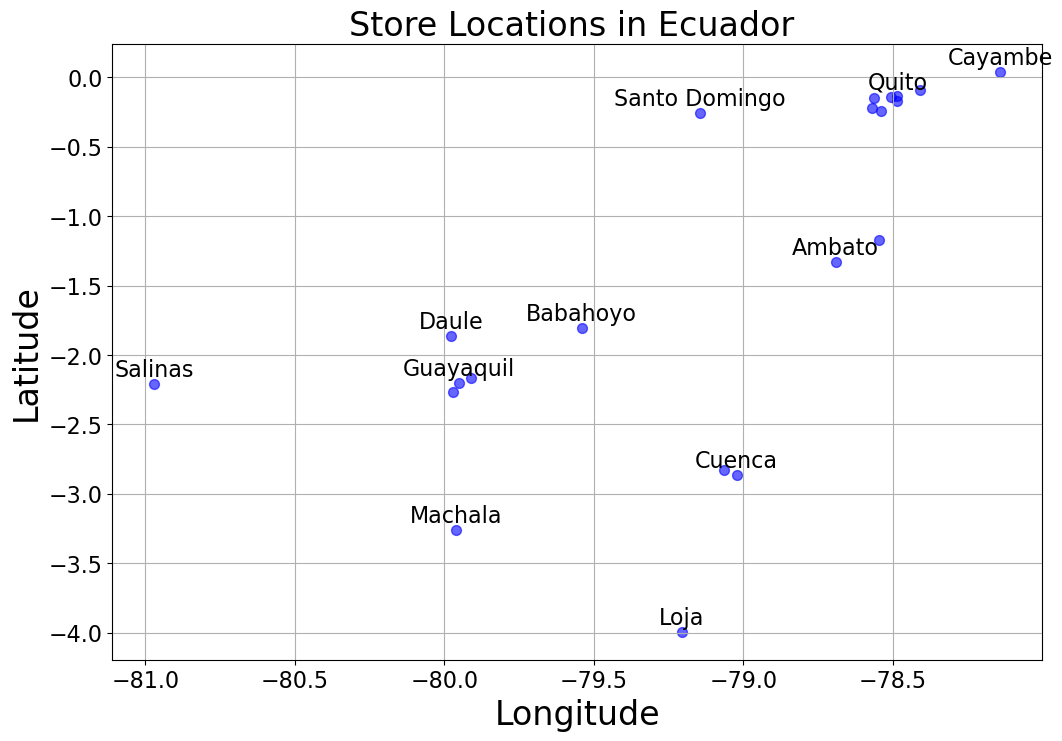


Number of stores per city:
city
Quito            7
Guayaquil        3
Ambato           2
Cuenca           2
Santo Domingo    1
Cayambe          1
Salinas          1
Daule            1
Babahoyo         1
Loja             1
Machala          1
Name: count, dtype: int64


In [44]:
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt

# -----------------------------
# 1. Define store data and selection
# -----------------------------

# Create a DataFrame for the 54 stores

# best_stores = results[35]['stores']

data = [
    [1, "Quito", "Pichincha", "D", 13],
    [2, "Quito", "Pichincha", "D", 13],
    [3, "Quito", "Pichincha", "D", 8],
    [4, "Quito", "Pichincha", "D", 9],
    [5, "Santo Domingo", "Santo Domingo de los Tsachilas", "D", 4],
    [6, "Quito", "Pichincha", "D", 13],
    [7, "Quito", "Pichincha", "D", 8],
    [8, "Quito", "Pichincha", "D", 8],
    [9, "Quito", "Pichincha", "B", 6],
    [10, "Quito", "Pichincha", "C", 15],
    [11, "Cayambe", "Pichincha", "B", 6],
    [12, "Latacunga", "Cotopaxi", "C", 15],
    [13, "Latacunga", "Cotopaxi", "C", 15],
    [14, "Riobamba", "Chimborazo", "C", 7],
    [15, "Ibarra", "Imbabura", "C", 15],
    [16, "Santo Domingo", "Santo Domingo de los Tsachilas", "C", 3],
    [17, "Quito", "Pichincha", "C", 12],
    [18, "Quito", "Pichincha", "B", 16],
    [19, "Guaranda", "Bolivar", "C", 15],
    [20, "Quito", "Pichincha", "B", 6],
    [21, "Santo Domingo", "Santo Domingo de los Tsachilas", "B", 6],
    [22, "Puyo", "Pastaza", "C", 7],
    [23, "Ambato", "Tungurahua", "D", 9],
    [24, "Guayaquil", "Guayas", "D", 1],
    [25, "Salinas", "Santa Elena", "D", 1],
    [26, "Guayaquil", "Guayas", "D", 10],
    [27, "Daule", "Guayas", "D", 1],
    [28, "Guayaquil", "Guayas", "E", 10],
    [29, "Guayaquil", "Guayas", "E", 10],
    [30, "Guayaquil", "Guayas", "C", 3],
    [31, "Babahoyo", "Los Rios", "B", 10],
    [32, "Guayaquil", "Guayas", "C", 3],
    [33, "Quevedo", "Los Rios", "C", 3],
    [34, "Guayaquil", "Guayas", "B", 6],
    [35, "Playas", "Guayas", "C", 3],
    [36, "Libertad", "Guayas", "E", 10],
    [37, "Cuenca", "Azuay", "D", 2],
    [38, "Loja", "Loja", "D", 4],
    [39, "Cuenca", "Azuay", "B", 6],
    [40, "Machala", "El Oro", "C", 3],
    [41, "Machala", "El Oro", "D", 4],
    [42, "Cuenca", "Azuay", "D", 2],
    [43, "Esmeraldas", "Esmeraldas", "E", 10],
    [44, "Quito", "Pichincha", "A", 5],
    [45, "Quito", "Pichincha", "A", 11],
    [46, "Quito", "Pichincha", "A", 14],
    [47, "Quito", "Pichincha", "A", 14],
    [48, "Quito", "Pichincha", "A", 14],
    [49, "Quito", "Pichincha", "A", 11],
    [50, "Ambato", "Tungurahua", "A", 14],
    [51, "Guayaquil", "Guayas", "A", 17],
    [52, "Manta", "Manabi", "A", 11],
    [53, "Manta", "Manabi", "D", 13],
    [54, "El Carmen", "Manabi", "C", 3]
]
columns = ["store_nbr", "city", "state", "type", "cluster"]
stores_df = pd.DataFrame(data, columns=columns)

# Filter stores to only include those in top_n_stores
stores_df = stores_df[stores_df['store_nbr'].isin(best_stores)]

# Group stores by city
city_groups = stores_df.groupby("city")
# Find cities with >1 store (multi-store) and with exactly 1 store (single-store)
multi_store_cities = [city for city, group in city_groups if len(group) > 1]
single_store_cities = [city for city, group in city_groups if len(group) == 1]

selected_stores = stores_df.reset_index(drop=True)
print("Total selected stores:", len(selected_stores))

# -----------------------------
# 2. Assign coordinates based on city centers
# -----------------------------
# Original dictionary: keys are city names, values are (lon, lat) tuples
city_coords = {
    "Esmeraldas": (-79.6545, 0.9682),
    "Ibarra": (-78.1165, 0.3517),
    "Cayambe": (-78.1416, 0.0412),
    "Quito": (-78.4678, -0.1807),
    "Santo Domingo": (-79.1459, -0.253),
    "Manta": (-80.7214, -0.9682),
    "Latacunga": (-78.6131, -0.9352),
    "El Carmen": (-79.8413, -0.3944),
    "Quevedo": (-79.4632, -1.0281),
    "Puyo": (-78.0035, -1.4921),
    "Ambato": (-78.6197, -1.2491),
    "Riobamba": (-78.6546, -1.6636),
    "Babahoyo": (-79.5400, -1.8022),
    "Daule": (-79.9775, -1.8619),
    "Guayaquil": (-79.8891, -2.1709),
    "Libertad": (-80.9182, -2.2333),
    "Playas": (-80.3895, -2.6333),
    "Salinas": (-80.9693, -2.2072),
    "Cuenca": (-79.0059, -2.9006),
    "Machala": (-79.9616, -3.2581),
    "Loja": (-79.2050, -3.9931),
    "Guaranda": (-79.0000, -1.5900),
}

rng = np.random.RandomState(1)  # Fixed seed for reproducibility

# Function to add random noise (simulate dispersion within a city's area)
def random_location(city, noise=0.1):  # noise in degrees
    if city in city_coords:
        base_lon, base_lat = city_coords[city]
        # Only add noise if city has multiple stores
        if city in multi_store_cities:
            lon = base_lon + rng.uniform(-noise, noise)
            lat = base_lat + rng.uniform(-noise, noise)
        else:
            lon, lat = base_lon, base_lat
        return lon, lat
    else:
        return np.nan, np.nan

# Assign coordinates for each store
lons, lats = [], []
for idx, row in selected_stores.iterrows():
    lon, lat = random_location(row["city"])
    lons.append(lon)
    lats.append(lat)
selected_stores["lon"] = lons
selected_stores["lat"] = lats

# Create the plot
plt.figure(figsize=(12, 8))

# Plot each store location
plt.scatter(selected_stores["lon"], selected_stores["lat"], c='blue', alpha=0.6, s=50)

# Add city names as labels
labeled_cities = set()
for _, store in selected_stores.iterrows():
    if store["city"] not in labeled_cities:
        plt.annotate(store["city"], 
                    (store["lon"], store["lat"]),
                    fontsize=16,  # Doubled from 16
                    ha='center',
                    va='center',
                    xytext=(0, 10),
                    textcoords='offset points')
        labeled_cities.add(store["city"])

plt.xlabel("Longitude", fontsize=24)  # Added fontsize
plt.ylabel("Latitude", fontsize=24)  # Added fontsize
plt.title(f"Store Locations in Ecuador ", fontsize=24)  # Added fontsize
plt.xticks(fontsize=16)  # Added tick fontsize
plt.yticks(fontsize=16)  # Added tick fontsize
plt.grid(True)
plt.show()

# Count stores per city
stores_per_city = selected_stores['city'].value_counts()

print("\nNumber of stores per city:")
print(stores_per_city)


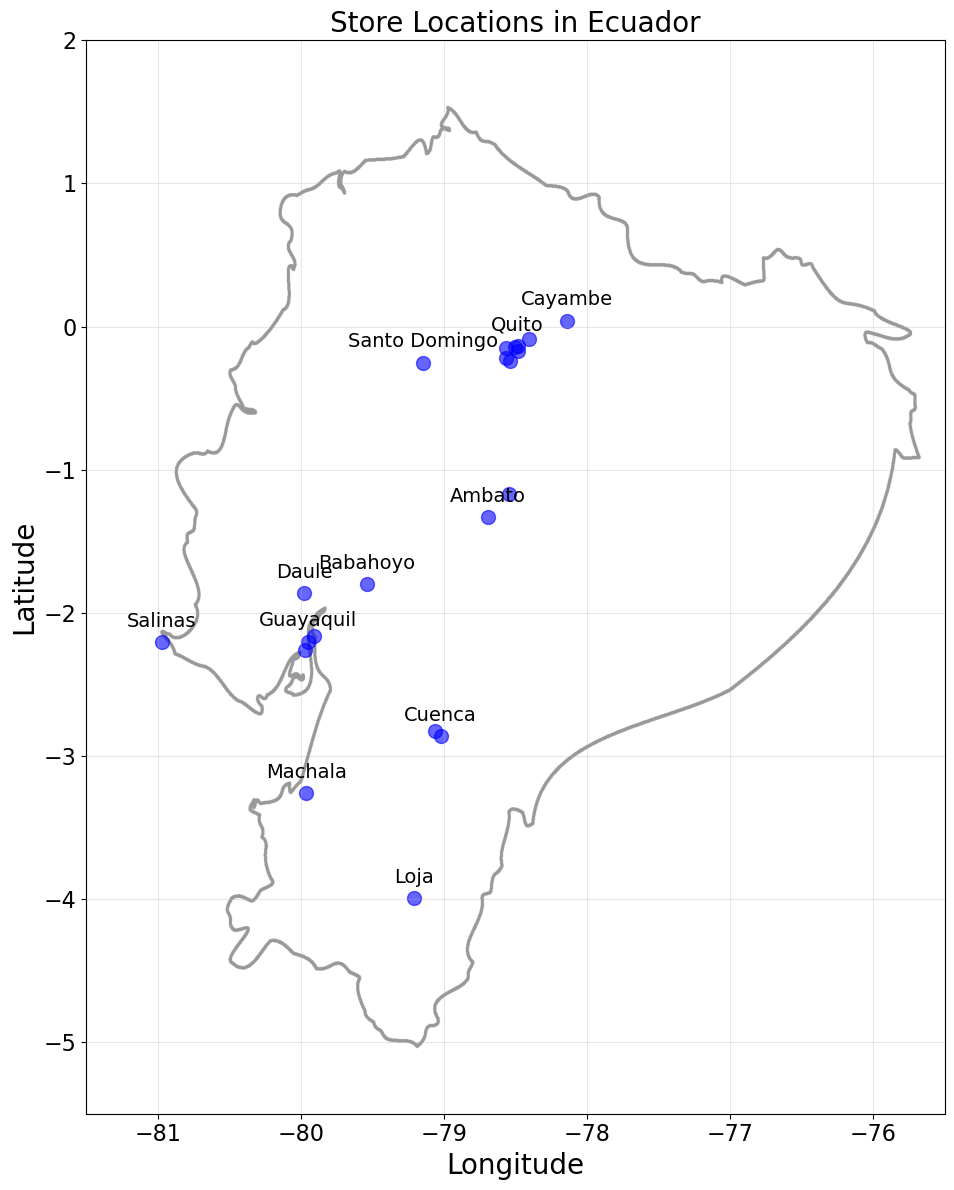

In [59]:
# Read and display Ecuador map
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

try:
    # Read the EPS file
    from PIL import Image
    import io
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(16, 12))  # Increased figure size
    
    # Try to read the EPS file
    img = mpimg.imread('Outline_Simple_Map_of_Ecuador.eps')
    
    # Display the image with accurate Ecuador coordinates
    # Using Ecuador's actual longitude/latitude boundaries
    plt.imshow(img, extent=[-82.15, -74.5, -6, 2.5], alpha=0.4)  # Added low alpha for transparency
    
    # Plot each store location with larger markers
    plt.scatter(selected_stores["lon"], selected_stores["lat"], c='blue', alpha=0.6, s=100)  # Increased marker size

    # Add city names as labels with more spacing
    labeled_cities = set()
    for _, store in selected_stores.iterrows():
        if store["city"] not in labeled_cities:
            plt.annotate(store["city"], 
                        (store["lon"], store["lat"]),
                        fontsize=14,  # Increased font size
                        ha='center',
                        va='center',
                        xytext=(0, 15),  # Increased vertical offset
                        textcoords='offset points')
            labeled_cities.add(store["city"])
    
    plt.title("Store Locations in Ecuador", fontsize=20)  # Increased title size
    plt.xlabel("Longitude", fontsize=20)  # Increased label size
    plt.ylabel("Latitude", fontsize=20)  # Increased label size
    
    # Set axis limits with more padding
    plt.xlim([-81.5, -75.5])  # Expanded longitude range
    plt.ylim([-5.5, 2.0])     # Expanded latitude range
    plt.xticks(fontsize=16)  # Added tick fontsize
    plt.yticks(fontsize=16)  # Added tick fontsize
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()  # Added to ensure all elements fit well
    plt.show()

except Exception as e:
    print(f"Error loading map: {e}")
    print("Please ensure 'Doodle_Map_of_Ecuador_With_States.eps' file exists in the working directory")


In [ ]:
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt

# -----------------------------
# 1. Define store data and selection
# -----------------------------

# Create a DataFrame for the 54 stores

# best_stores = results[35]['stores']

data = [
    [1, "Quito", "Pichincha", "D", 13],
    [2, "Quito", "Pichincha", "D", 13],
    [3, "Quito", "Pichincha", "D", 8],
    [4, "Quito", "Pichincha", "D", 9],
    [5, "Santo Domingo", "Santo Domingo de los Tsachilas", "D", 4],
    [6, "Quito", "Pichincha", "D", 13],
    [7, "Quito", "Pichincha", "D", 8],
    [8, "Quito", "Pichincha", "D", 8],
    [9, "Quito", "Pichincha", "B", 6],
    [10, "Quito", "Pichincha", "C", 15],
    [11, "Cayambe", "Pichincha", "B", 6],
    [12, "Latacunga", "Cotopaxi", "C", 15],
    [13, "Latacunga", "Cotopaxi", "C", 15],
    [14, "Riobamba", "Chimborazo", "C", 7],
    [15, "Ibarra", "Imbabura", "C", 15],
    [16, "Santo Domingo", "Santo Domingo de los Tsachilas", "C", 3],
    [17, "Quito", "Pichincha", "C", 12],
    [18, "Quito", "Pichincha", "B", 16],
    [19, "Guaranda", "Bolivar", "C", 15],
    [20, "Quito", "Pichincha", "B", 6],
    [21, "Santo Domingo", "Santo Domingo de los Tsachilas", "B", 6],
    [22, "Puyo", "Pastaza", "C", 7],
    [23, "Ambato", "Tungurahua", "D", 9],
    [24, "Guayaquil", "Guayas", "D", 1],
    [25, "Salinas", "Santa Elena", "D", 1],
    [26, "Guayaquil", "Guayas", "D", 10],
    [27, "Daule", "Guayas", "D", 1],
    [28, "Guayaquil", "Guayas", "E", 10],
    [29, "Guayaquil", "Guayas", "E", 10],
    [30, "Guayaquil", "Guayas", "C", 3],
    [31, "Babahoyo", "Los Rios", "B", 10],
    [32, "Guayaquil", "Guayas", "C", 3],
    [33, "Quevedo", "Los Rios", "C", 3],
    [34, "Guayaquil", "Guayas", "B", 6],
    [35, "Playas", "Guayas", "C", 3],
    [36, "Libertad", "Guayas", "E", 10],
    [37, "Cuenca", "Azuay", "D", 2],
    [38, "Loja", "Loja", "D", 4],
    [39, "Cuenca", "Azuay", "B", 6],
    [40, "Machala", "El Oro", "C", 3],
    [41, "Machala", "El Oro", "D", 4],
    [42, "Cuenca", "Azuay", "D", 2],
    [43, "Esmeraldas", "Esmeraldas", "E", 10],
    [44, "Quito", "Pichincha", "A", 5],
    [45, "Quito", "Pichincha", "A", 11],
    [46, "Quito", "Pichincha", "A", 14],
    [47, "Quito", "Pichincha", "A", 14],
    [48, "Quito", "Pichincha", "A", 14],
    [49, "Quito", "Pichincha", "A", 11],
    [50, "Ambato", "Tungurahua", "A", 14],
    [51, "Guayaquil", "Guayas", "A", 17],
    [52, "Manta", "Manabi", "A", 11],
    [53, "Manta", "Manabi", "D", 13],
    [54, "El Carmen", "Manabi", "C", 3]
]
columns = ["store_nbr", "city", "state", "type", "cluster"]
stores_df = pd.DataFrame(data, columns=columns)

# Filter stores to only include those in top_n_stores
stores_df = stores_df[stores_df['store_nbr'].isin(best_stores)]

# Group stores by city
city_groups = stores_df.groupby("city")
# Find cities with >1 store (multi-store) and with exactly 1 store (single-store)
multi_store_cities = [city for city, group in city_groups if len(group) > 1]
single_store_cities = [city for city, group in city_groups if len(group) == 1]

selected_stores = stores_df.reset_index(drop=True)
print("Total selected stores:", len(selected_stores))

# -----------------------------
# 2. Assign coordinates based on city centers
# -----------------------------
# Original dictionary: keys are city names, values are (lon, lat) tuples
city_coords = {
    "Esmeraldas": (-79.6545, 0.9682),
    "Ibarra": (-78.1165, 0.3517),
    "Cayambe": (-78.1416, 0.0412),
    "Quito": (-78.4678, -0.1807),
    "Santo Domingo": (-79.1459, -0.253),
    "Manta": (-80.7214, -0.9682),
    "Latacunga": (-78.6131, -0.9352),
    "El Carmen": (-79.8413, -0.3944),
    "Quevedo": (-79.4632, -1.0281),
    "Puyo": (-78.0035, -1.4921),
    "Ambato": (-78.6197, -1.2491),
    "Riobamba": (-78.6546, -1.6636),
    "Babahoyo": (-79.5400, -1.8022),
    "Daule": (-79.9775, -1.8619),
    "Guayaquil": (-79.8891, -2.1709),
    "Libertad": (-80.9182, -2.2333),
    "Playas": (-80.3895, -2.6333),
    "Salinas": (-80.9607, -2.2117),
    "Cuenca": (-79.0059, -2.9006),
    "Machala": (-79.9616, -3.2581),
    "Loja": (-79.2050, -3.9931),
    "Guaranda": (-79.0000, -1.5900),
}

rng = np.random.RandomState(1)  # Fixed seed for reproducibility

# Function to add random noise (simulate dispersion within a city's area)
def random_location(city, noise=0.05):  # noise in degrees
    if city in city_coords:
        base_lon, base_lat = city_coords[city]
        # Only add noise if city has multiple stores
        if city in multi_store_cities:
            lon = base_lon + rng.uniform(-noise, noise)
            lat = base_lat + rng.uniform(-noise, noise)
        else:
            lon, lat = base_lon, base_lat
        return lon, lat
    else:
        return np.nan, np.nan

# Assign coordinates for each store
lons, lats = [], []
for idx, row in selected_stores.iterrows():
    lon, lat = random_location(row["city"])
    lons.append(lon)
    lats.append(lat)
selected_stores["lon"] = lons
selected_stores["lat"] = lats

# Create the plot
plt.figure(figsize=(12, 8))

# Plot each store location
plt.scatter(selected_stores["lon"], selected_stores["lat"], c='blue', alpha=0.6, s=50)

# Add city names as labels
labeled_cities = set()
for _, store in selected_stores.iterrows():
    if store["city"] not in labeled_cities:
        plt.annotate(store["city"], 
                    (store["lon"], store["lat"]),
                    fontsize=16,  # Doubled from 16
                    ha='center',
                    va='center',
                    xytext=(0, 10),
                    textcoords='offset points')
        labeled_cities.add(store["city"])

plt.xlabel("Longitude", fontsize=24)  # Added fontsize
plt.ylabel("Latitude", fontsize=24)  # Added fontsize
plt.title(f"Store Locations in Ecuador ", fontsize=24)  # Added fontsize
plt.xticks(fontsize=16)  # Added tick fontsize
plt.yticks(fontsize=16)  # Added tick fontsize
plt.grid(True)
plt.show()

# Count stores per city
stores_per_city = selected_stores['city'].value_counts()

print("\nNumber of stores per city:")
print(stores_per_city)


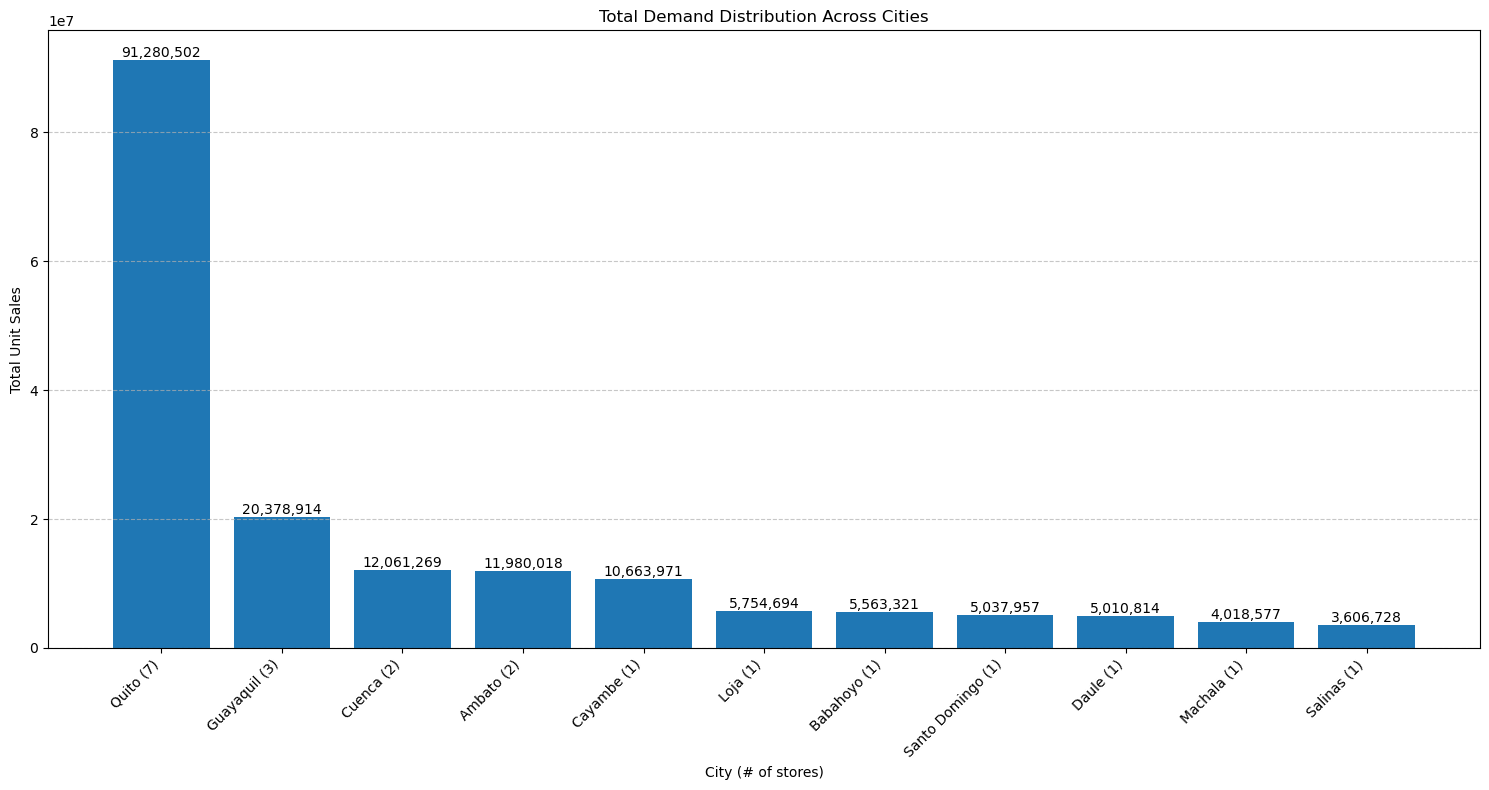

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate total demand for each store
store_total_demands = {}
for _, row in df_ts_filtered.iterrows():
    store_nbr = row['store_nbr']
    # Sum all demand values (all columns except item_nbr and store_nbr)
    total_demand = row.iloc[2:].sum()
    
    if store_nbr in store_total_demands:
        store_total_demands[store_nbr] += total_demand
    else:
        store_total_demands[store_nbr] = total_demand

# Merge with store information to get city data
store_demands_df = pd.DataFrame({
    'store_nbr': list(store_total_demands.keys()),
    'total_demand': list(store_total_demands.values())
})

# Merge with selected_stores to get city information
# Using selected_stores instead of best_stores which seems to be causing the IndexError
store_city_demands = pd.merge(store_demands_df, selected_stores[['store_nbr', 'city']], on='store_nbr')

# Aggregate demands by city
city_demands = store_city_demands.groupby('city')['total_demand'].sum().reset_index()
city_demands = city_demands.sort_values('total_demand', ascending=False)

# Count stores per city
stores_count = selected_stores['city'].value_counts().to_dict()

# Create x-axis labels with city name and store count
x_labels = [f"{city} ({stores_count[city]})" for city in city_demands['city']]

# Create the plot
plt.figure(figsize=(15, 8))
bars = plt.bar(x_labels, city_demands['total_demand'])

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom', rotation=0)

plt.title('Total Demand Distribution Across Cities')
plt.xlabel('City (# of stores)')
plt.ylabel('Total Unit Sales')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [22]:
# Print store numbers of selected_stores
print("Store numbers in selected_stores:")
print(selected_stores['store_nbr'].unique())


Store numbers in selected_stores:
[ 3  5  8 11 27 28 31 34 37 38 39 41 44 45 46 47 48 49 50 51]
